# **Image Classification Model for CIFAR-10 dataset using Resnet**

### Part 1: Data Preprocessing

In [1]:
# LIBRARIES IMPORT
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

1.1 LOAD DATASET AND PERFORM EDA.

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [3]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


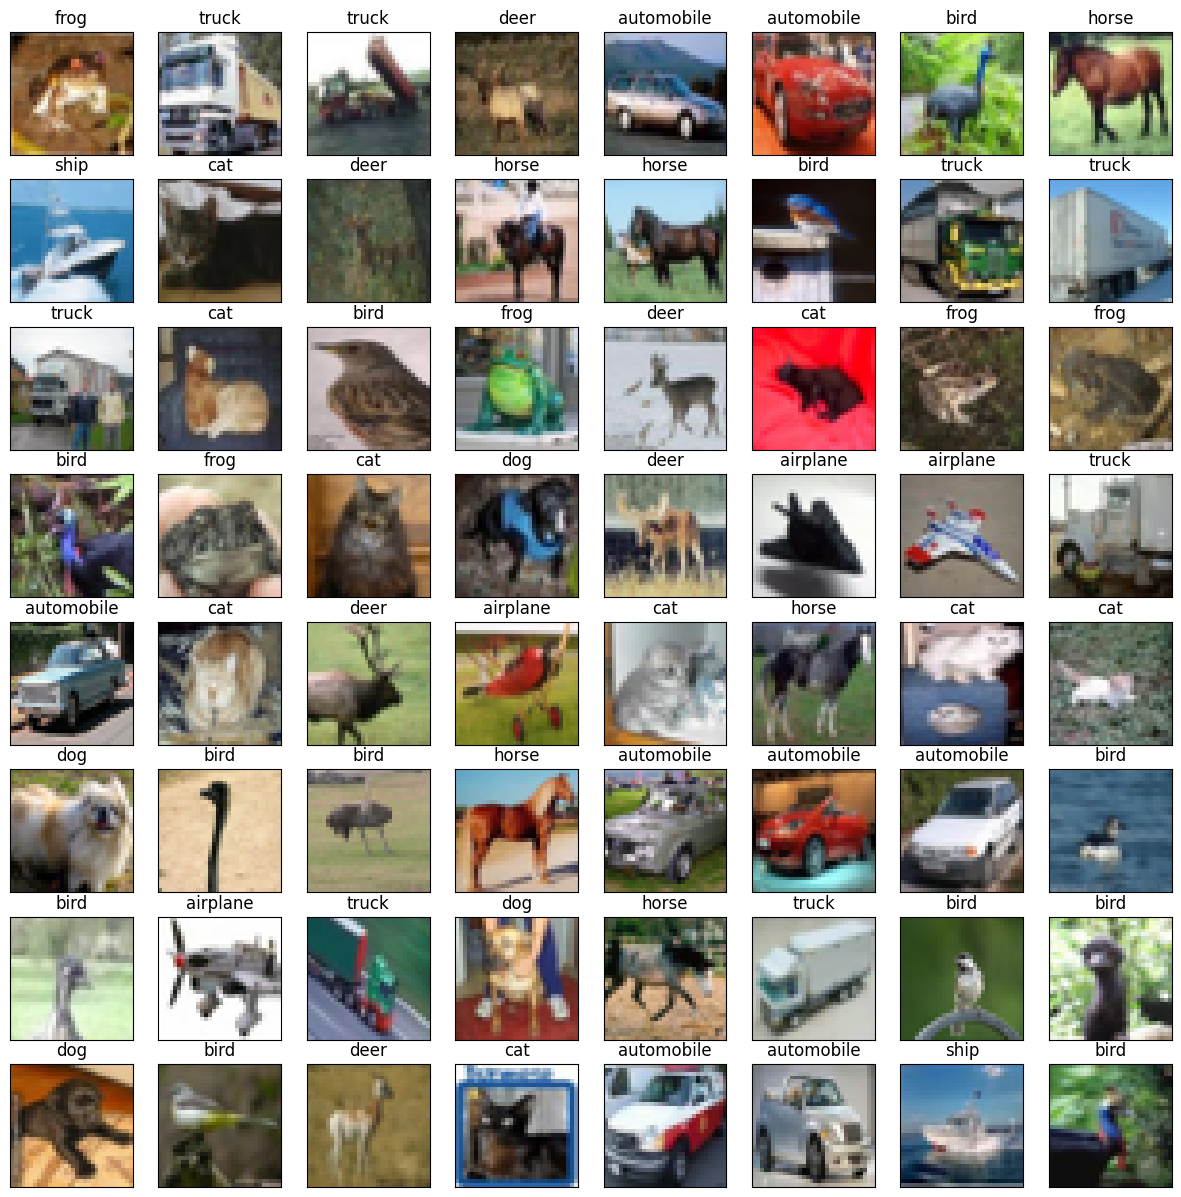

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # label as title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

Text(0.5, 1.0, 'Class distribution in training set')

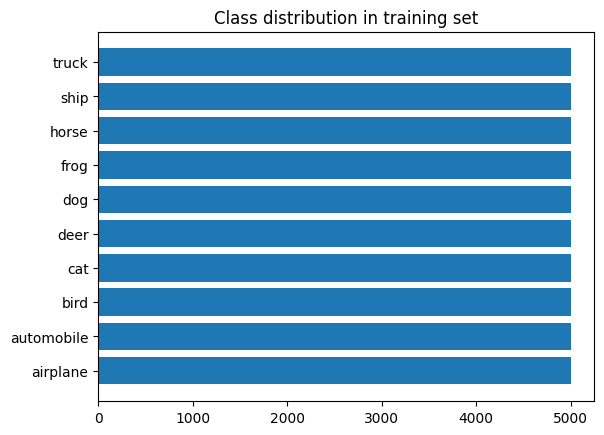

In [5]:
classes, counts = np.unique(y_train, return_counts=True)
plt.barh(class_names, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

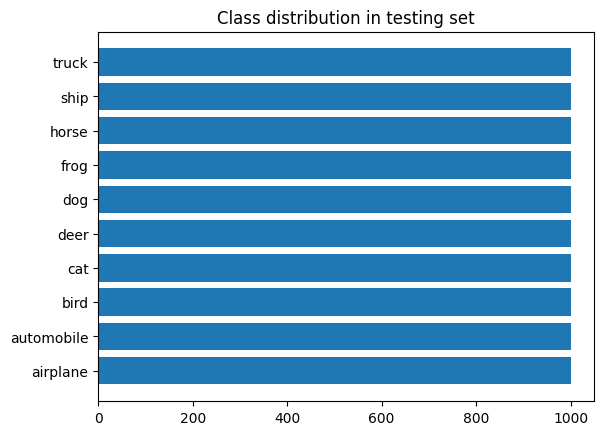

In [6]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(class_names, counts)
plt.title('Class distribution in testing set')

Equal Distribution is present in all the classes in both training and testing sets

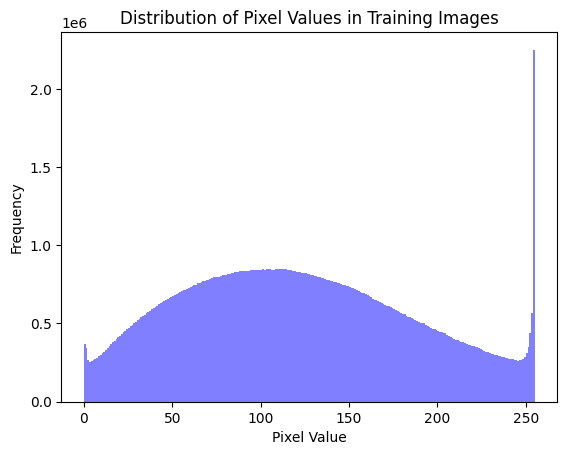

In [7]:
# Distribution of pixel values
plt.hist(X_train.flatten(), bins=255, color='blue', alpha=0.5)
plt.title("Distribution of Pixel Values in Training Images")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

1.2 Split the dataset into training, validation, and testing sets.

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


1.3 Preprocess images: resize, normalize pixel values, and apply data augmentation techniques.


In [ ]:
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_valid = X_valid / 255.0

num_classes=10
y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)
y_test  = to_categorical(y_test, num_classes)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(X_train)

### Part 2: Model Training and Evaluation

#### 2.1: CNN architecture(RESNET from Scratch Approach).

In [ ]:
def residual_block(x, filters, strides=1):
    # Shortcut
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust shortcut if necessary
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x


def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    # Initial convolution layer
    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Stage 1
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Stage 2
    x = residual_block(x, filters=128, strides=2)
    x = residual_block(x, filters=128)

    # Stage 3
    x = residual_block(x, filters=256, strides=2)
    x = residual_block(x, filters=256)

    # Stage 4
    x = residual_block(x, filters=512, strides=2)
    x = residual_block(x, filters=512)

    # Global average pooling and fully connected layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs)
    return model


model = build_resnet18()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 16, 16, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 8, 8, 64)       │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 8, 64)       │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 64)       │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 8, 8, 64)       │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 8, 8, 64)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 8, 8, 64)       │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 8, 8, 64)       │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 11,196,042 (42.71 MB)

 Trainable params: 11,186,442 (42.67 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 67s 62ms/step - accuracy: 0.3616 - loss: 1.8745 - val_accuracy: 0.3704 - val_loss: 1.7276 - learning_rate: 0.0010
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.5309 - loss: 1.3235 - val_accuracy: 0.5074 - val_loss: 1.4743 - learning_rate: 0.0010
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5980 - loss: 1.1374 - val_accuracy: 0.5692 - val_loss: 1.2065 - learning_rate: 0.0010
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.6400 - loss: 1.0244 - val_accuracy: 0.6226 - val_loss: 1.0858 - learning_rate: 0.0010
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.6649 - loss: 0.9520 - val_accuracy: 0.5240 - val_loss: 1.4582 - learning_rate: 0.0010
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6926 - loss: 0.8897 - val_accuracy: 0.6120 - val_loss: 1.1323 - learning_rate: 0.0010
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.6913 - l

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8435 - loss: 0.4841
Test Accuracy: 0.8451


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

    airplane       0.86      0.88      0.87      1000
  automobile       0.90      0.94      0.92      1000
        bird       0.87      0.75      0.80      1000
         cat       0.72      0.68      0.70      1000
        deer       0.86      0.81      0.83      1000
         dog       0.78      0.74      0.76      1000
        frog       0.82      0.93      0.87      1000
       horse       0.85      0.91      0.88      1000
        ship       0.93      0.90      0.92      1000
       truck       0.86      0.91      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.84      0.85      0.84     10000
weighted avg       0.84      0.85      0.84     10000



In [ ]:
print(confusion_matrix(y_true_classes, y_pred_classes))

[[878  16  17  12   5   1   5   8  26  32]
 [  4 936   0   4   0   0   2   1   8  45]
 [ 35   2 752  51  40  30  57  21   4   8]
 [ 18   8  28 680  31 125  57  27   9  17]
 [  6   3  33  23 806  21  40  59   4   5]
 [ 10   7  15 122  29 744  27  35   4   7]
 [  3   6  14  26   9   9 928   2   1   2]
 [  7   2   8  21  15  21   4 911   2   9]
 [ 40  17   1   7   1   1   2   3 903  25]
 [ 17  47   1   5   0   1   3   5   8 913]]


In [ ]:
model.save('cifar10_resnet18_model.h5')

In [ ]:
model.save('cifar10_resnet18_model.keras')

#### 2.2: Evaluate the Model.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate precision and recall
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 0.8451
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Precision: 0.8447
Recall: 0.8451
Classification Report:
              precision    recall  f1-score   support

    airplane       0.86      0.88      0.87      1000
  automobile       0.90      0.94      0.92      1000
        bird       0.87      0.75      0.80      1000
         cat       0.72      0.68      0.70      1000
        deer       0.86      0.81      0.83      1000
         dog       0.78      0.74      0.76      1000
        frog       0.82      0.93      0.87      1000
       horse       0.85      0.91      0.88      1000
        ship       0.93      0.90      0.92      1000
       truck       0.86      0.91      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.84      0.85      0.84     10000
weighted avg       0.84      0.85      0.84     10000

Confusion Matrix:
[[878  16  17  12   5   1   5   8  26  32]
 [  4 936   0   4   0   0   2   1   8  45]
 [ 35   2 752  51 

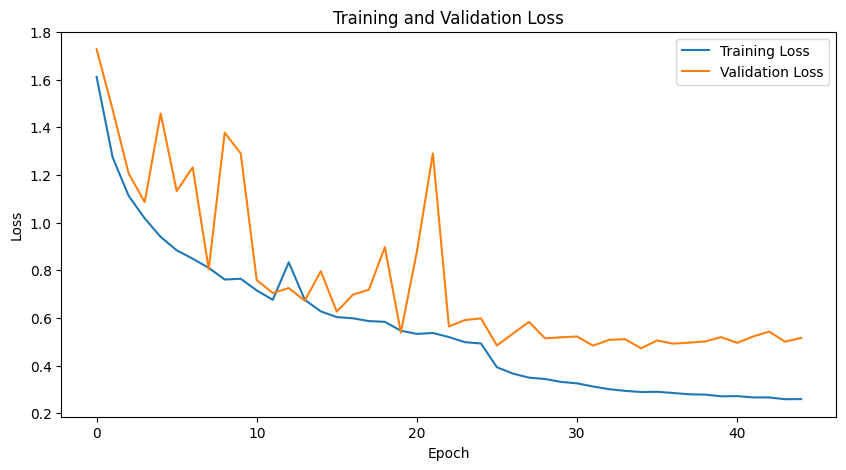

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

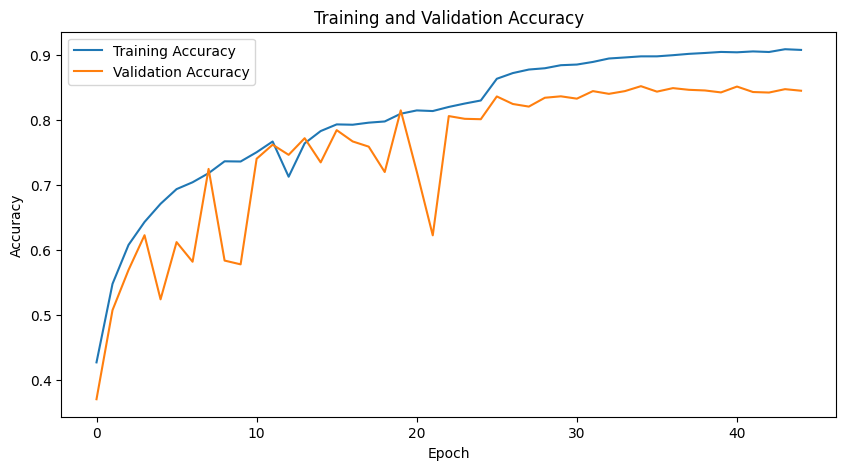

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

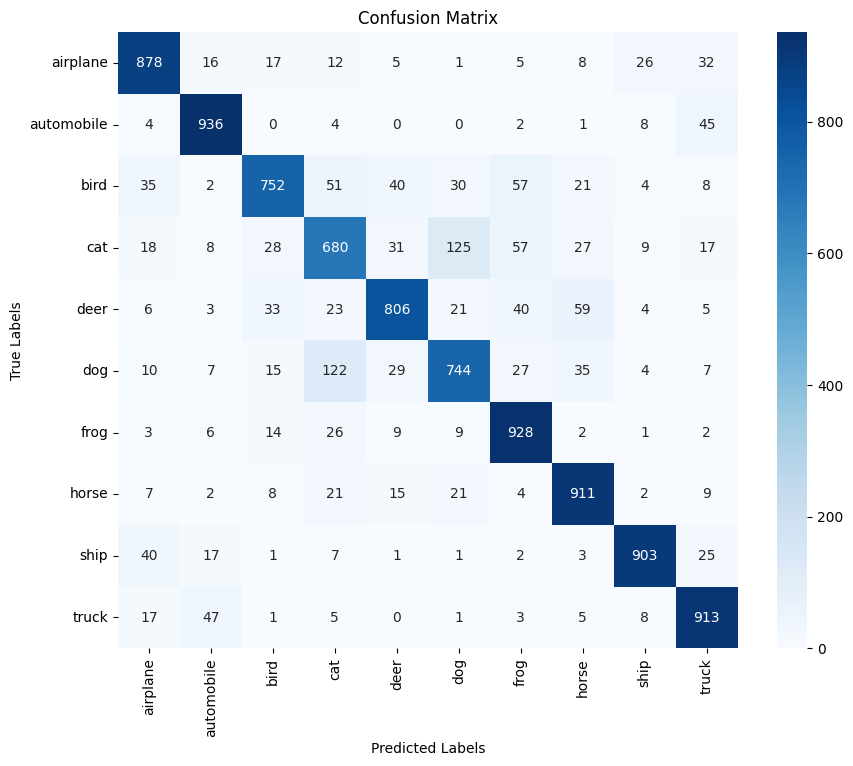

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### 2.3: CNN architecture(RESNET from Library Approach).

In [13]:
from tensorflow.keras.applications import ResNet50

# Load pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 26,162,698 (99.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=40,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 120s 90ms/step - accuracy: 0.4523 - loss: 1.6723 - val_accuracy: 0.1618 - val_loss: 3.1955 - learning_rate: 0.0010
Epoch 2/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.6296 - loss: 1.0965 - val_accuracy: 0.5344 - val_loss: 1.8987 - learning_rate: 0.0010
Epoch 3/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.5996 - loss: 1.1608 - val_accuracy: 0.6960 - val_loss: 0.8855 - learning_rate: 0.0010
Epoch 4/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.6849 - loss: 0.9310 - val_accuracy: 0.7022 - val_loss: 0.8880 - learning_rate: 0.0010
Epoch 5/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.6986 - loss: 0.9030 - val_accuracy: 0.5828 - val_loss: 1.4044 - learning_rate: 0.0010
Epoch 6/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.7351 - loss: 0.7787 - val_accuracy: 0.4994 - val_loss: 1.8358 - learning_rate: 0.0010
Epoch 7/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.7469 - 

In [15]:
model.save('resnet50_pretrained_model.h5')

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate precision and recall
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 0.8614
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step
Precision: 0.8609
Recall: 0.8614
Classification Report:
              precision    recall  f1-score   support

    airplane       0.90      0.87      0.88      1000
  automobile       0.90      0.94      0.92      1000
        bird       0.84      0.83      0.84      1000
         cat       0.74      0.71      0.72      1000
        deer       0.87      0.82      0.85      1000
         dog       0.83      0.74      0.78      1000
        frog       0.83      0.96      0.89      1000
       horse       0.88      0.92      0.90      1000
        ship       0.92      0.92      0.92      1000
       truck       0.89      0.90      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Confusion Matrix:
[[866  11  24  12   4   3  13   7  34  26]
 [  3 944   1   3   0   0   6   0   7  36]
 [ 25   2 833  2

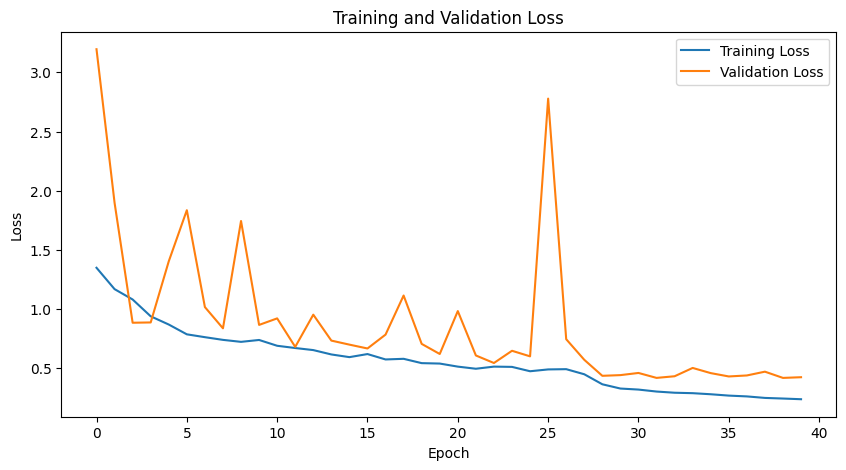

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

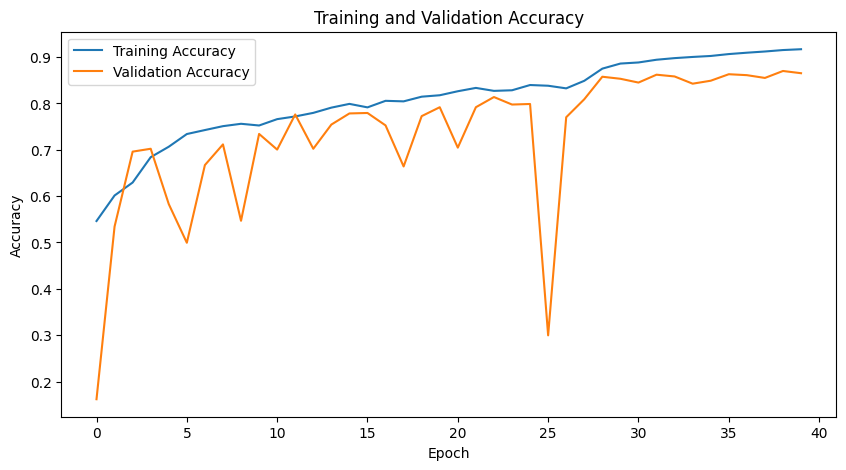

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

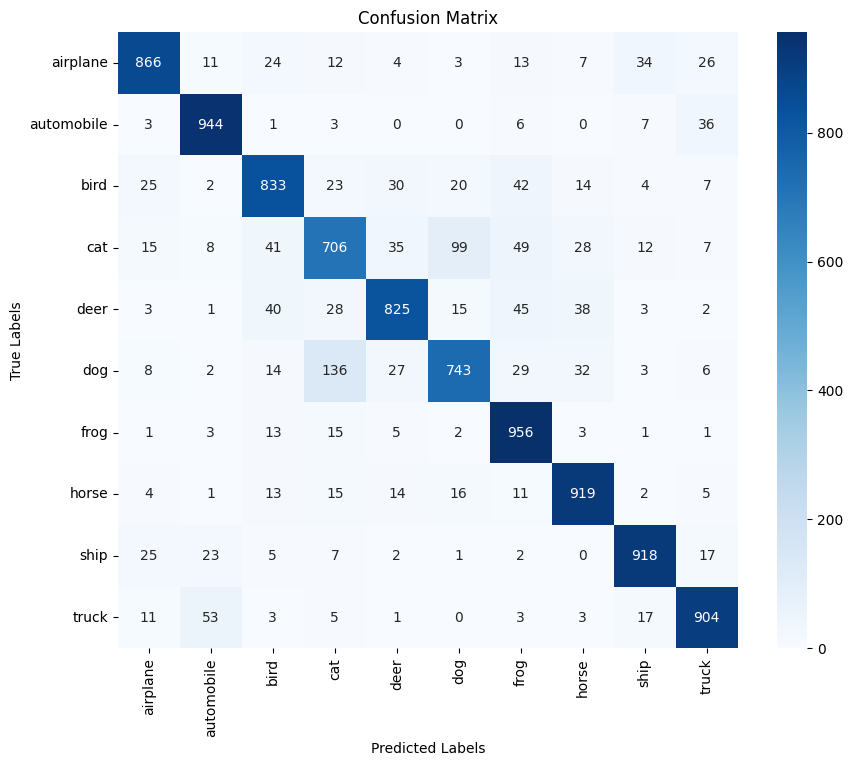

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()